---
# Import Libraries

---

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from collections import Counter
import random
from collections import defaultdict
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
import time
import copy
from torchvision.utils import make_grid
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


---
# Load Dataset

---

In [2]:
train_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train"
test_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test"

train_dataset = datasets.ImageFolder(root=train_dir)
test_dataset = datasets.ImageFolder(root= test_dir)

num_classes = len(train_dataset.classes)
total_samples = len(train_dataset.samples)
print("# of Classes: ", num_classes)
print("# of Training smaples: ", total_samples)

print("______________________________________\n")

class_counts = Counter([sample[1] for sample in train_dataset.samples])
print("# of training samples in each class:\n")

for i, count in class_counts.items():
    print(f'{train_dataset.classes[i]}: {count} samples')

print("______________________________________\n")



# of Classes:  196
# of Training smaples:  8144
______________________________________

# of training samples in each class:

AM General Hummer SUV 2000: 45 samples
Acura Integra Type R 2001: 45 samples
Acura RL Sedan 2012: 32 samples
Acura TL Sedan 2012: 43 samples
Acura TL Type-S 2008: 42 samples
Acura TSX Sedan 2012: 41 samples
Acura ZDX Hatchback 2012: 39 samples
Aston Martin V8 Vantage Convertible 2012: 45 samples
Aston Martin V8 Vantage Coupe 2012: 41 samples
Aston Martin Virage Convertible 2012: 33 samples
Aston Martin Virage Coupe 2012: 38 samples
Audi 100 Sedan 1994: 41 samples
Audi 100 Wagon 1994: 43 samples
Audi A5 Coupe 2012: 41 samples
Audi R8 Coupe 2012: 43 samples
Audi RS 4 Convertible 2008: 37 samples
Audi S4 Sedan 2007: 45 samples
Audi S4 Sedan 2012: 40 samples
Audi S5 Convertible 2012: 42 samples
Audi S5 Coupe 2012: 43 samples
Audi S6 Sedan 2011: 46 samples
Audi TT Hatchback 2011: 41 samples
Audi TT RS Coupe 2012: 40 samples
Audi TTS Coupe 2012: 43 samples
Audi V8 Sed

### Inspecting the Test Set

The test set contains the same class labels as the training data but includes fewer samples.


In [3]:
num_classes = len(test_dataset.classes)
total_samples = len(test_dataset.samples)
print("# of Classes: ", num_classes)
print("# of Training smaples: ", total_samples)

print("______________________________________\n")

# of Classes:  196
# of Training smaples:  8041
______________________________________



### Exploring the Training Dataset

The next step is to examine the composition and structure of the training dataset.


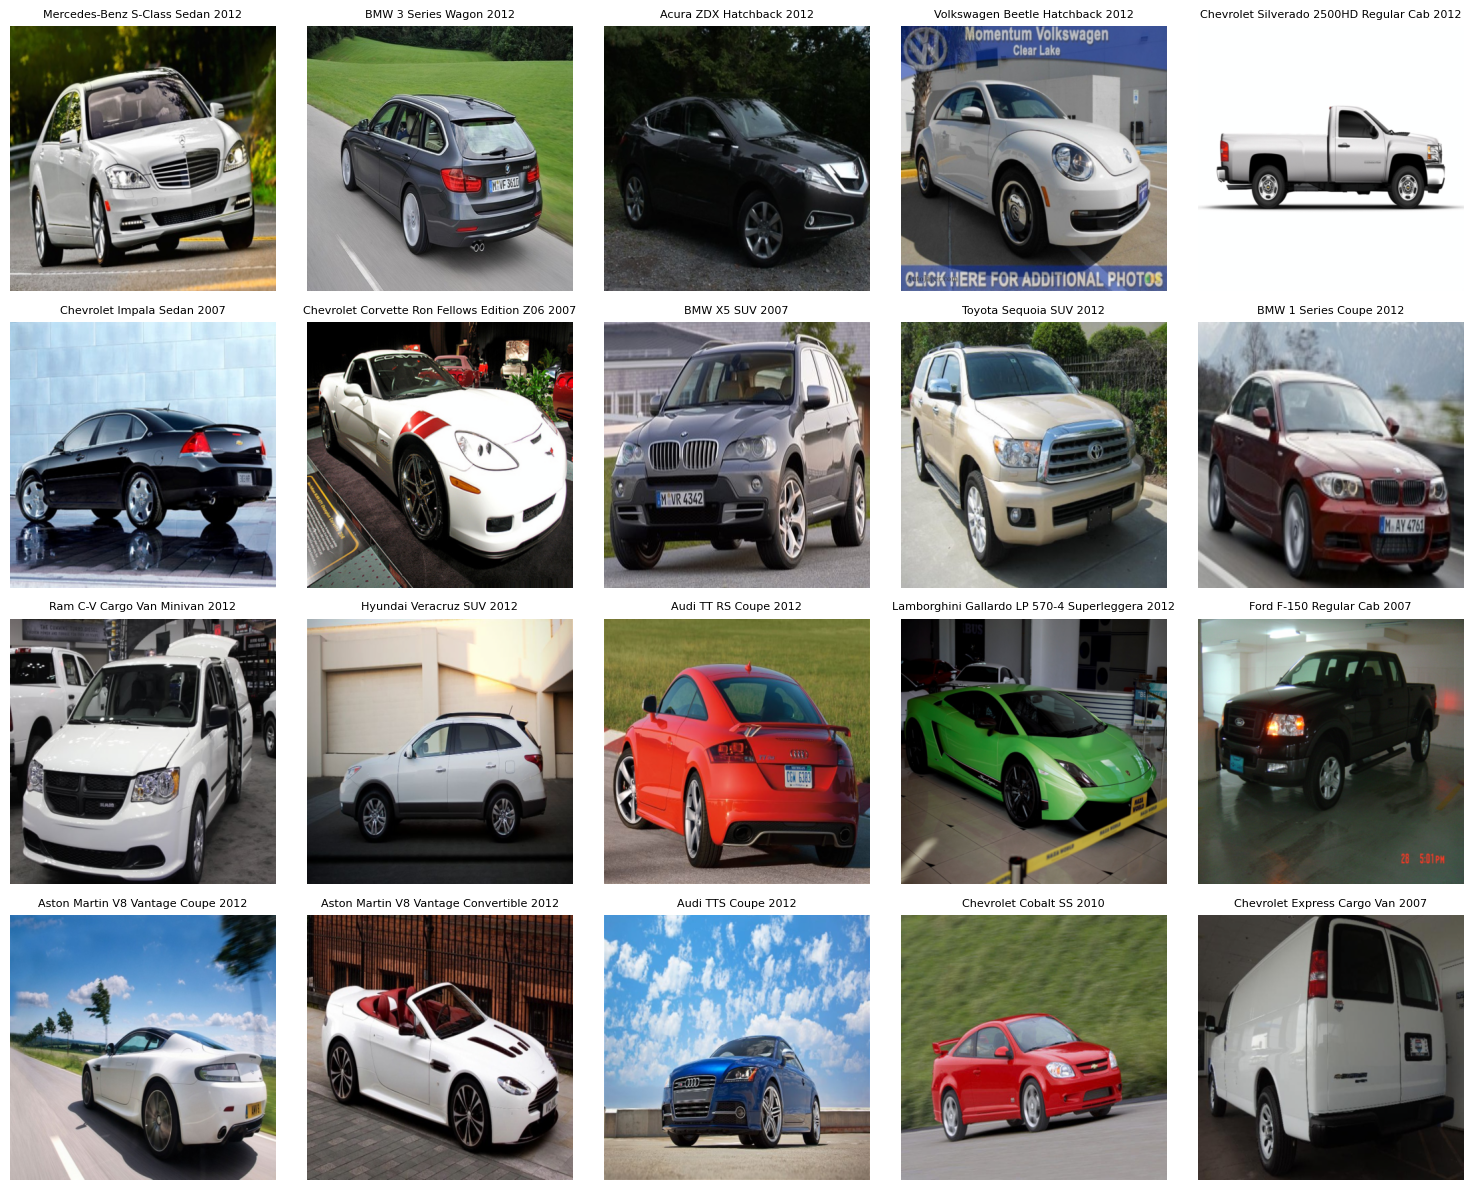

In [4]:
# ── reproducibility seeds ────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  

# ── normalization stats ────────────────────────────────────────────────────
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def unnormalize(img_tensor):
    """C×H×W → H×W×C in [0,1]"""
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)

# ── your data & transform ──────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((400,400)),
    transforms.CenterCrop(400),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# ── sample 20 classes and one image each ────────────────────────────────────
classes_to_show = 20
all_classes = dataset.classes
sampled_classes = random.sample(all_classes, classes_to_show)

# map class name → list of indices
cls2idxs = defaultdict(list)
for idx, (_, cls_idx) in enumerate(dataset.samples):
    cls2idxs[dataset.classes[cls_idx]].append(idx)

images, labels = [], []
for cls in sampled_classes:
    idx = random.choice(cls2idxs[cls])
    img_t, _ = dataset[idx]
    images.append(img_t)
    labels.append(cls)

# ── plot in a 4×5 grid ──────────────────────────────────────────────────────
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for ax, img_t, lbl in zip(axes.flatten(), images, labels):
    ax.imshow(unnormalize(img_t))
    ax.set_title(lbl, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

---
## Data Loading and Augmentation

In this section, we load the dataset and apply data augmentation techniques to enhance the model's robustness and generalization during training.

---

In [5]:
# transforms on train and test set 
train_transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std = std)])
test_transform = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std = std)])

train_set = datasets.ImageFolder(root= train_dir, transform = train_transform)
test_set = datasets.ImageFolder(root= test_dir, transform = test_transform)

train_loader = DataLoader(train_set, batch_size = 32, shuffle=True, num_workers = 2)
test_loader = DataLoader( test_set,batch_size = 32, shuffle=False, num_workers = 2)



## Model Definition

In [6]:
model = models.resnet18(pretrained=True)

# Replace the final layer for 196 classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


model = models.resnet18(pretrained=True)

#changeing classification head to match our dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(all_classes))
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Reduce LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training and Evaluation

In [12]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=loss.item())

    acc = 100 * correct / total
    return running_loss / len(loader), acc


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    progress_bar = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

    acc = 100 * correct / total
    return running_loss / len(loader), acc, y_true, y_pred

In [13]:
class_names = train_set.classes
def run_training(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=10, save_path="best_model.pth"):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc, y_true, y_pred = evaluate(model, test_loader, criterion)

        scheduler.step(val_loss)

        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
        print("-" * 50)

        # Save best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print("✅ Best model saved!")

    total_time = time.time() - start_time
    print(f"\n⏱️ Total training time: {total_time/60:.2f} minutes")

    # Load best weights
    model.load_state_dict(best_model_wts)
    
    # Final evaluation report
    print("\n✅ Final Evaluation:")
    overall_acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {overall_acc * 100:.2f}%")

    # Get full classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix for 20 selected classes
    cm = confusion_matrix(y_true, y_pred)
    
    # Select 20 class indices (random or fixed)
    selected_indices = sorted(random.sample(range(len(class_names)), 20))
    selected_names = [class_names[i] for i in selected_indices]

    # Filter confusion matrix
    cm_20 = cm[np.ix_(selected_indices, selected_indices)]

    # Plot filtered confusion matrix
    fig, ax = plt.subplots(figsize=(12, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_20, display_labels=selected_names)
    disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix (20 Classes Subset)")
    plt.tight_layout()
    plt.show()


Epoch 1/1


Training:   0%|          | 0/255 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/252 [00:00<?, ?it/s]

  Train Loss: 0.1236 | Train Acc: 98.74%
  Val   Loss: 0.5225 | Val   Acc: 88.36%
--------------------------------------------------
✅ Best model saved!

⏱️ Total training time: 2.13 minutes

✅ Final Evaluation:
Accuracy: 88.36%

Classification Report:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.93      0.95      0.94        44
                             Acura Integra Type R 2001       0.97      0.89      0.93        44
                                   Acura RL Sedan 2012       0.91      0.62      0.74        32
                                   Acura TL Sedan 2012       0.87      0.79      0.83        43
                                  Acura TL Type-S 2008       0.97      0.90      0.94        42
                                  Acura TSX Sedan 2012       0.66      0.95      0.78        40
                              Acura ZDX Hatchback 2012       0.94      0.8

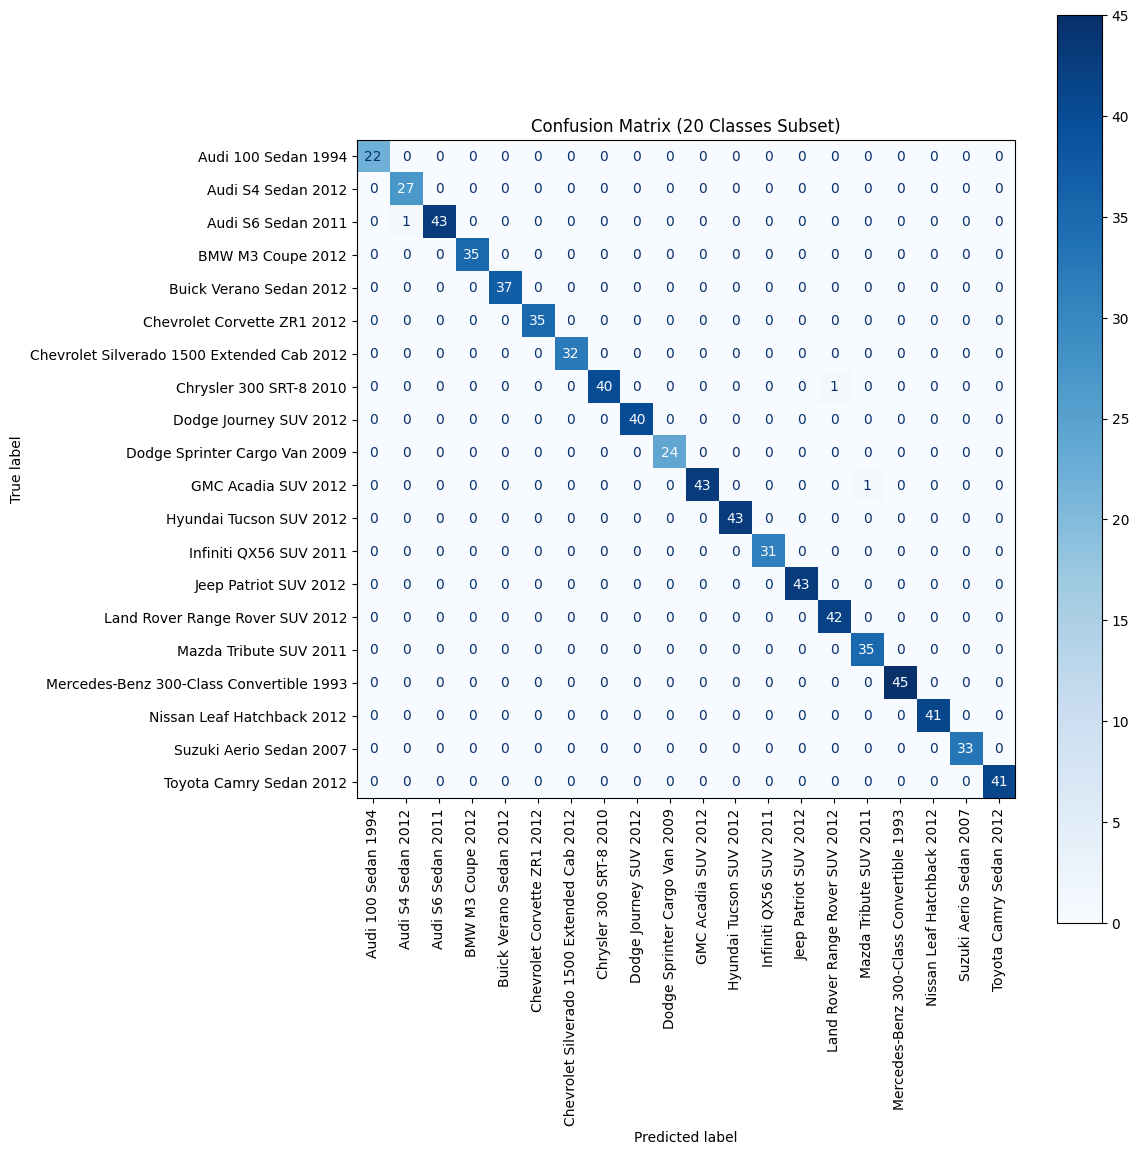

In [14]:
run_training(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=1)


In [15]:
def visualize_random_predictions(model, dataset, class_names, num_samples=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    images, true_labels, pred_labels, confidences = [], [], [], []

    with torch.no_grad():
        for idx in indices:
            img, label = dataset[idx]
            input_img = img.unsqueeze(0).to(device)
            output = model(input_img)
            probs = F.softmax(output, dim=1)
            conf, pred = torch.max(probs, 1)

            images.append(img)
            true_labels.append(label)
            pred_labels.append(pred.item())
            confidences.append(conf.item())

    # Plot in 2x5 grid
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, ax in enumerate(axes.flatten()):
        img = images[i].permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
        img = torch.clamp(img, 0, 1).numpy()

        true_name = class_names[true_labels[i]]
        pred_name = class_names[pred_labels[i]]
        conf = confidences[i]

        ax.imshow(img)
        ax.set_title(f"GT: {true_name}\nPred: {pred_name} ({conf:.2f})", fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

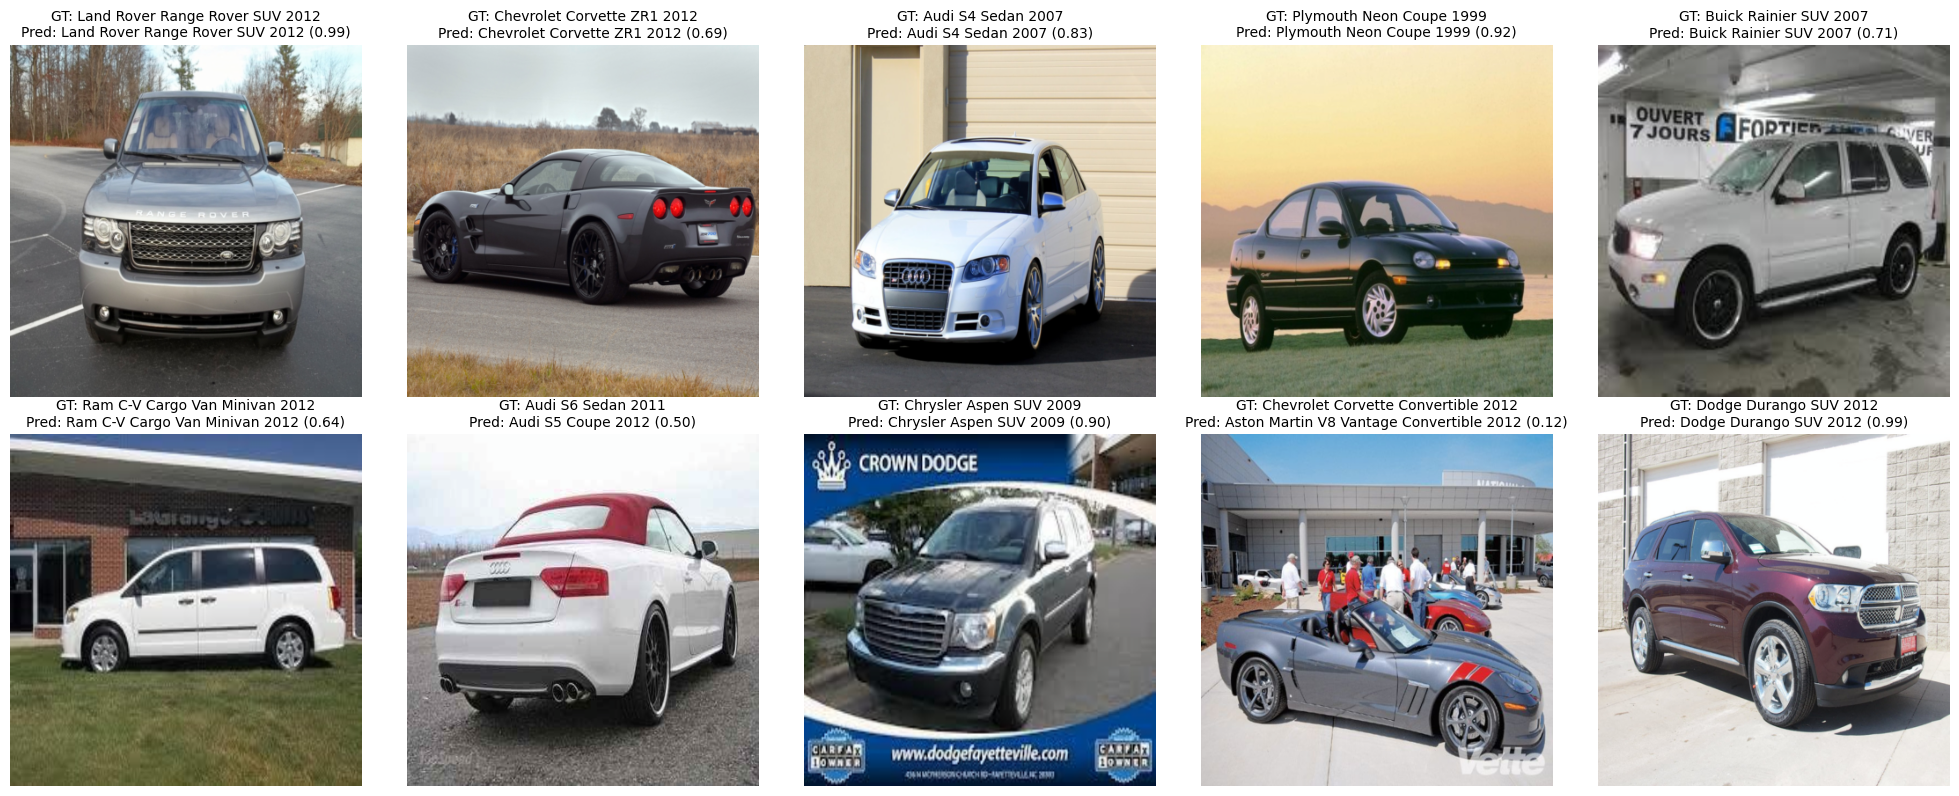

In [16]:
visualize_random_predictions(model, test_set, class_names, num_samples=10)
